In [1]:
import torch, time, copy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.quantization import prepare, convert
from src.utils import *
from src.override_resnet import *


model = resnet50_quan(weights=pretrained_weights_mapping[50])
model.to("cuda")
model.eval()

# set fuse ############################################################
model = fuse_ALL(model)

for name, module in model.named_modules():
    if len(name) > 2 and name[-7:] == "through":

        module.qconfig = torch.quantization.QConfig(
            activation=torch.quantization.RecordingObserver.with_args(
                dtype=torch.quint8
            ),
            weight=None,
        )
        print(f"{name} | {module.qconfig}")
        break
        
prepare(model, inplace=True)

# calibrate the model ############################################################
criterion = nn.CrossEntropyLoss()
train_loader, _ = GetDataset(
    dataset_name="ImageNet",
    device="cuda",
    root="data",
    batch_size=32,
    num_workers=8,
)


layer1.0.through | QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.RecordingObserver'>, dtype=torch.quint8){}, weight=None)


In [2]:
num_of_iter = 32
print(SingleEpochEval(model, train_loader, criterion, "cuda", num_of_iter))

# for name, module in model.named_modules():
#     print(name, module)

  0%|          | 32/40037 [00:01<39:55, 16.70it/s] 

(0.9846745282411575, 92.1875)


layer1.0.through
(32, 32, 256, 56, 56)



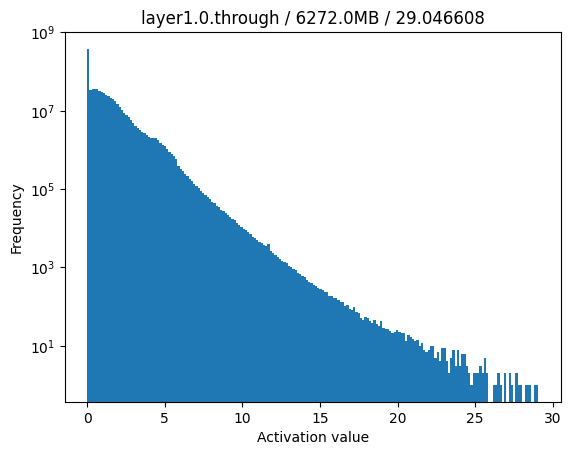

std : 1.1118870973587036
mean : 0.780785083770752
max : 29.046607971191406
min : 0.0
median : 0.2985975742340088


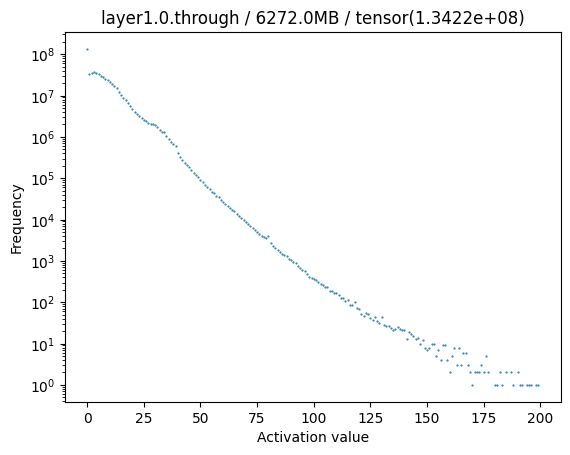

6272.0 MB


In [3]:
# %%
all_activation_size = 0

dja = None
for name, module in model.named_modules():
    if (
        len(name) > 2
        and name[-7:] == "through"
        and hasattr(module, "activation_post_process")
    ):
        print(f"{name}")

        _hist = list()

        # print(len(module.activation_post_process.get_tensor_value())) # the len of batch size

        for x in module.activation_post_process.get_tensor_value():
            _hist.append(x.clone().detach().to("cpu"))

        _hist = np.array(_hist)
        print(_hist.shape)
        cnt = 1
        for i in _hist.shape:
            cnt *= i
        fp32_activation_size = cnt * 8 / 1024 / 1024
        all_activation_size += fp32_activation_size

        print("")

        _hist = _hist.flatten()

        dja = _hist

        plt.hist(_hist, 200)
        plt.title(
            name + " / " + str(fp32_activation_size) + "MB" + " / " + str(max(_hist))
        )
        plt.yscale("log")
        plt.xlabel("Activation value")
        plt.ylabel("Frequency")
        plt.show()
        
        ####################################################################

        
        print(f"std : {np.std(_hist)}")
        print(f"mean : {np.mean(_hist)}")
        print(f"max : {np.max(_hist)}")
        print(f"min : {np.min(_hist)}")
        print(f"median : {np.median(_hist)}")

        _hist = torch.histc(torch.tensor(_hist), bins=200, min=0, max=max(_hist))
        plt.scatter(range(len(_hist)), _hist, s=0.3)
        plt.title(name + " / " + str(fp32_activation_size) + "MB" + " / " + str(max(_hist)))
        plt.yscale("log")
        plt.xlabel("Activation value")
        plt.ylabel("Frequency")
        plt.show()

        break
print(all_activation_size, "MB")

In [4]:
print(all_activation_size * len(train_loader) / num_of_iter / 1024 / 1024, "TB")

7.483722686767578 TB


In [5]:
def outlier_iqr(data):
    q25, q75 = np.quantile(data, 0.25), np.quantile(data, 0.75)
    iqr = q75 - q25

    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    print("IQR은", iqr, "이다.")
    print("lower bound 값은", lower, "이다.")
    print("upper bound 값은", upper, "이다.")

    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기
    data1 = data[data > upper]
    data2 = data[data < lower]

    # 이상치 총 개수 구하기
    print("총 이상치 개수는", data1.shape[0] + data2.shape[0], "이다.\n")
    numofoutlier = data1.shape[0] + data2.shape[0]
    return lower, upper, numofoutlier


lower, upper, numofoutlier = outlier_iqr(dja)

IQR은 1.2252228558063507 이다.
lower bound 값은 -1.837834283709526 이다.
upper bound 값은 3.0630571395158768 이다.
총 이상치 개수는 39176752 이다.



In [6]:
dja = torch.tensor(dja)
print("outlier per : ",(len(dja) - numofoutlier) / len(dja))
print("len of hist : ", len(dja))

outlier per :  0.9523445635425801
len of hist :  822083584


In [7]:
sum_last_numofoutlier= torch.sum(dja[-numofoutlier:])
print("sum last outliers : ", sum_last_numofoutlier.item())

sum last outliers :  30521036.0


In [8]:
total = torch.sum(dja).item()
print("total : ", total)

total :  641872640.0


In [9]:
print("sum of inner values per : ", (total-sum_last_numofoutlier)/total)

sum of inner values per :  tensor(0.9525)
